👉 Upload your image (e.g., aeval1.bmp).


Saving aeval1.bmp to aeval1.bmp
Loaded: aeval1.bmp


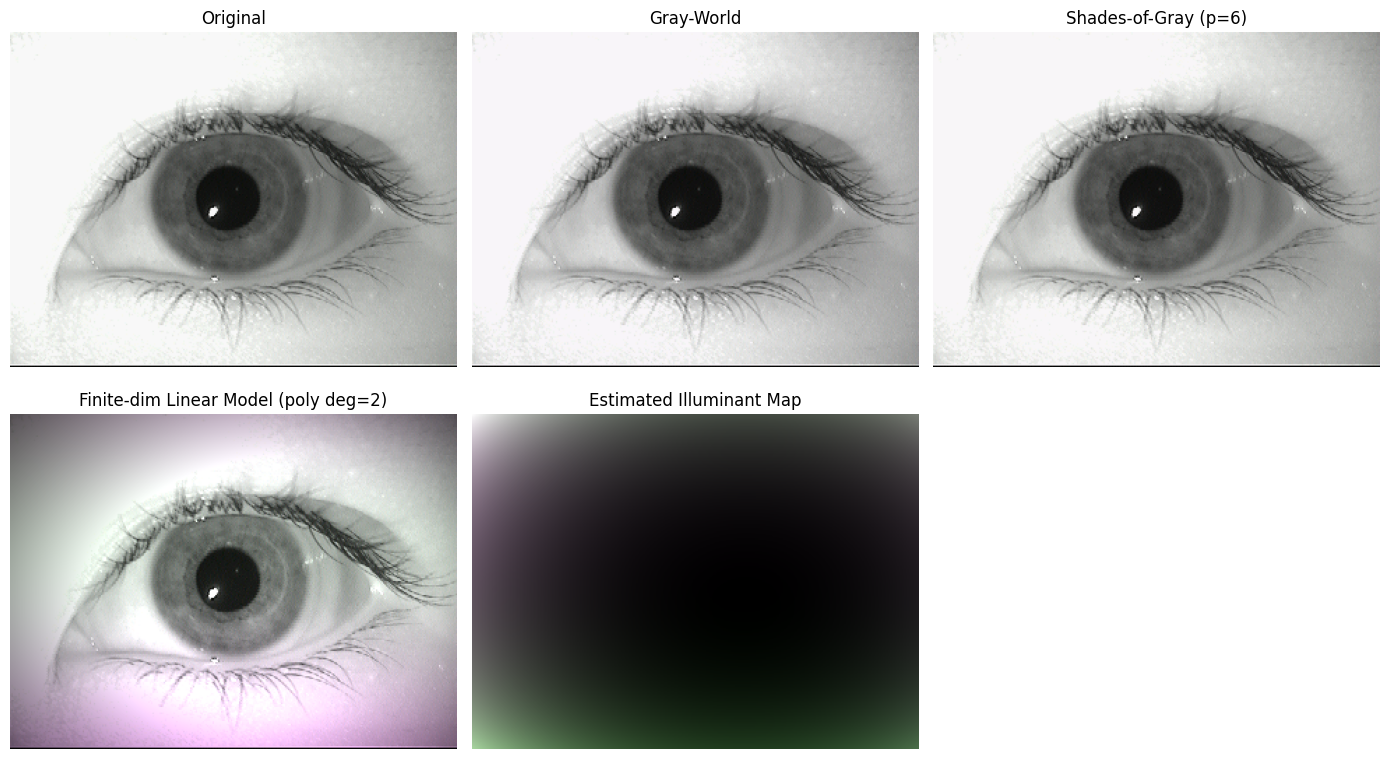

Saved outputs: original_rgb.png, gray_world.png, shades_of_gray.png, fd_linear_model.png, illuminant_map.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
# ===========================
# Color Constancy: Gray-World + Finite-Dim Linear Model
# (Google Colab ready)
# ===========================
!pip install -q opencv-python-headless matplotlib numpy

import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# ---------------------------
# Utility functions
# ---------------------------
def imread_rgb(path):
    bgr = cv2.imread(path, cv2.IMREAD_COLOR)
    if bgr is None:
        raise FileNotFoundError(f"Cannot read '{path}'")
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    return rgb

def imsave_rgb(path, rgb):
    bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
    cv2.imwrite(path, bgr)

def scale_and_clip(img):
    img = np.clip(img, 0, 255)
    return img.astype(np.uint8)

# ---------------------------
# 1) Gray-World
# ---------------------------
def gray_world(img):
    # img: HxWx3 in float (0..255)
    eps = 1e-8
    mean_per_channel = img.reshape(-1,3).mean(axis=0) + eps
    # Illuminant estimate is mean_per_channel
    # Normalize to make green channel 1 (or use L2 norm)
    e = mean_per_channel
    scale = np.mean(e)  # keep average brightness similar
    gains = scale / e
    corrected = img * gains[None,None,:]
    return scale_and_clip(corrected), e, gains

# ---------------------------
# 2) Shades-of-Gray (p-norm)
# ---------------------------
def shades_of_gray(img, p=6):
    eps = 1e-8
    abs_pow = (np.abs(img) + eps) ** p
    mean_p = abs_pow.reshape(-1,3).mean(axis=0)
    e = (mean_p) ** (1.0/p) + eps
    scale = np.mean(e)
    gains = scale / e
    corrected = img * gains[None,None,:]
    return scale_and_clip(corrected), e, gains

# ---------------------------
# 3) Finite-dimensional linear model (polynomial basis) in log-domain
#    Model: log e_c(x,y) = sum_k a_{c,k} * phi_k(x,y)
#    Fit a_{c,k} by linear least squares: A a = t  where t = log I_c
# ---------------------------
def build_poly_basis(h, w, degree=2):
    # returns design matrix A of shape (h*w, K) and basis functions shape (h,w,K)
    ys = np.linspace(-1,1,h)
    xs = np.linspace(-1,1,w)
    X, Y = np.meshgrid(xs, ys)  # shape (h,w)
    # generate polynomial terms up to 'degree' (total degree)
    terms = []
    for i in range(degree+1):
        for j in range(degree+1-i):
            terms.append((X**i)*(Y**j))
    B = np.stack(terms, axis=2)  # (h,w,K)
    A = B.reshape(-1, B.shape[2])  # (h*w, K)
    return A, B

def linear_model_log_domain(img, degree=2, eps=1e-6):
    # img: HxWx3 float (0..255)
    h, w, _ = img.shape
    A, B = build_poly_basis(h, w, degree=degree)  # A: (N,K)
    N, K = A.shape
    corrected = np.zeros_like(img)
    illuminant_map = np.zeros((h,w,3))
    coeffs = np.zeros((3, K))
    # operate per channel in log domain
    for c in range(3):
        t = np.log(img[:,:,c].reshape(-1) + eps)  # (N,)
        # Solve least squares: minimize ||A a - t||^2
        # regularize a bit to avoid overfitting (ridge)
        lam = 1e-3
        ATA = A.T @ A + lam * np.eye(K)
        ATt = A.T @ t
        a = np.linalg.solve(ATA, ATt)  # (K,)
        coeffs[c] = a
        log_e = (A @ a).reshape(h, w)  # estimated log illuminant per pixel
        e = np.exp(log_e)
        illuminant_map[:,:,c] = e
        # correct by dividing observed by e
        corrected[:,:,c] = img[:,:,c] / (e + eps)
    # To preserve overall brightness, scale corrected image so that its mean luminance ~= original mean luminance
    orig_mean = img.mean()
    corr_mean = corrected.mean()
    corrected = corrected * (orig_mean / (corr_mean + eps))
    corrected = scale_and_clip(corrected)
    return corrected, illuminant_map, coeffs

# ---------------------------
# Main: upload, run methods, and display
# ---------------------------
print("👉 Upload your image (e.g., aeval1.bmp).")
uploaded = files.upload()
if len(uploaded) == 0:
    raise SystemExit("No file uploaded.")
image_path = next(iter(uploaded.keys()))
print("Loaded:", image_path)

# Load as float
img_rgb = imread_rgb(image_path).astype(np.float32)

# Run Gray-World
gw_img, gw_e, gw_gains = gray_world(img_rgb)

# Shades-of-Gray
sog_img, sog_e, sog_gains = shades_of_gray(img_rgb, p=6)

# Finite-dimensional linear model (polynomial basis degree=2)
fd_img, illum_map, coeffs = linear_model_log_domain(img_rgb, degree=2)

# Save results
imsave_rgb("original_rgb.png", scale_and_clip(img_rgb))
imsave_rgb("gray_world.png", gw_img)
imsave_rgb("shades_of_gray.png", sog_img)
imsave_rgb("fd_linear_model.png", fd_img)

# Also save illuminant maps (visualize)
# normalize illuminant map for display
ill_vis = illum_map.copy()
for c in range(3):
    v = ill_vis[:,:,c]
    v = (v - v.min()) / (v.max() - v.min() + 1e-8)
    ill_vis[:,:,c] = v
imsave_rgb("illuminant_map.png", scale_and_clip(ill_vis*255.0))

# Display side-by-side
plt.figure(figsize=(14,8))
plt.subplot(2,3,1); plt.imshow(scale_and_clip(img_rgb)); plt.title("Original"); plt.axis('off')
plt.subplot(2,3,2); plt.imshow(gw_img); plt.title("Gray-World"); plt.axis('off')
plt.subplot(2,3,3); plt.imshow(sog_img); plt.title("Shades-of-Gray (p=6)"); plt.axis('off')
plt.subplot(2,3,4); plt.imshow(fd_img); plt.title("Finite-dim Linear Model (poly deg=2)"); plt.axis('off')
plt.subplot(2,3,5); plt.imshow(scale_and_clip(ill_vis*255.0)); plt.title("Estimated Illuminant Map"); plt.axis('off')
plt.tight_layout()
plt.show()

# Offer downloads
print("Saved outputs: original_rgb.png, gray_world.png, shades_of_gray.png, fd_linear_model.png, illuminant_map.png")
files.download("original_rgb.png")
files.download("gray_world.png")
files.download("shades_of_gray.png")
files.download("fd_linear_model.png")
files.download("illuminant_map.png")
